In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

import torchvision
from torchvision.utils import make_grid
from torchvision import transforms, datasets, models

from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
normalize = lambda x: (x - x.min()) / (x.max() - x.min())
model = models.googlenet(pretrained=True).to(device).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 91.5MB/s]


In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset = datasets.Imagenette(
    root='data/imagenette',
    split='train',
    size='320px',
    download=True,
    transform=transform
)

loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=False)

100%|██████████| 342M/342M [00:06<00:00, 50.7MB/s] 


In [3]:
indices = [0]
sample_images = torch.cat([dataset[idx][0].unsqueeze(0) for idx in indices], dim=0).to(device)
with torch.no_grad():
    logits = model(sample_images)
    probs = F.softmax(logits, dim=1)
    
prob, cls = torch.max(probs, dim=1)
prob, cls

(tensor([0.4085], device='cuda:0'), tensor([0], device='cuda:0'))

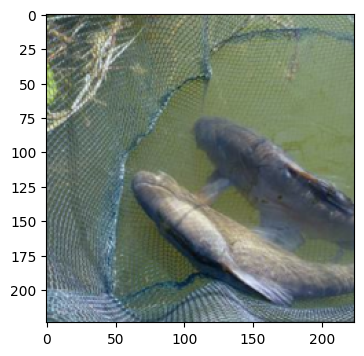

In [4]:
img_ = sample_images
img_ = normalize(img_)
img_ = make_grid(img_)
img_ = img_.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(16, 4))
plt.imshow(img_)

In [7]:
sample_images.requires_grad_(True)
logits = model(sample_images)
loss = F.cross_entropy(logits, cls)
model.zero_grad()
loss.backward()
sample_grad = sample_images.grad.data

epsilon = 0.01
perturbation = epsilon * sample_grad.sign()
adv_images = (sample_images + perturbation)

mean_ = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
std_ = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)
min_ = (0 - mean_) / std_
max_ = (1 - mean_) / std_
adv_images = torch.max(torch.min(adv_images, max_), min_)
with torch.no_grad():
    adv_logits = model(adv_images)
    adv_prob, adv_cls = torch.max(F.softmax(adv_logits, dim=1), dim=1)

adv_prob, adv_cls

(tensor([0.7713], device='cuda:0'), tensor([39], device='cuda:0'))

(-0.5, 223.5, 223.5, -0.5)

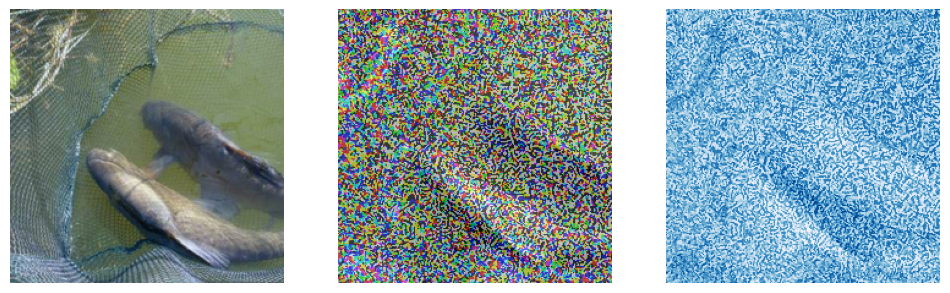

In [8]:
i_ = make_grid(adv_images.detach()).permute(1, 2, 0).cpu().numpy()
i_ = normalize(i_)
diff = i_ - img_
# min_diff = diff.min(axis=(1, 2, 3))
# max_diff = diff.max(axis=(1, 2, 3))

diff = normalize(diff)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(i_)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(diff)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(diff.mean(axis=2), cmap="Blues")
plt.axis("off")

In [9]:
class SparseAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.enc2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)

        self.dec1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        h = F.relu(self.enc2(x))
        
        x = F.relu(self.dec1(h))
        x = torch.sigmoid(self.dec2(x))
        return x, h

sae = SparseAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)
beta = 1e-2

for epoch in range(2):
    for imgs, _ in tqdm(loader):
        imgs = imgs.to(device)
        recon, h = sae(imgs)
        recon_loss = criterion(recon, imgs)
        sparse_loss = beta * h.abs().mean()
        loss = recon_loss + sparse_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 296/296 [00:34<00:00,  8.59it/s]


In [12]:
sae_preprocessing = transforms.Resize(64)

original_images = sae_preprocessing(sample_images[0]).unsqueeze(0).to(device)
adv_images = sae_preprocessing(torch.clamp(adv_images, min_, max_)[0]).unsqueeze(0).to(device)

with torch.no_grad():
    _, original_h = sae(original_images)
    _, adv_h = sae(adv_images)
    
diff = (original_h - adv_h).abs()
mean_diff = diff.mean().item()
channel_diff = diff.mean(dim=(0, 2, 3)).cpu()
top_channels = torch.argsort(channel_diff, descending=True)[:4]
top_channels.tolist()

[16, 30, 1, 18]

In [16]:
original_h[0, :, 0, 0]

tensor([0.0000, 0.8084, 0.3805, 0.0924, 0.0000, 0.0000, 0.0080, 0.0000, 0.0000,
        0.3925, 0.0000, 0.0000, 0.2748, 0.0000, 0.0000, 0.0000, 0.4950, 0.0000,
        0.4197, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0747, 0.0000, 0.0000, 0.4093, 0.2635], device='cuda:0')

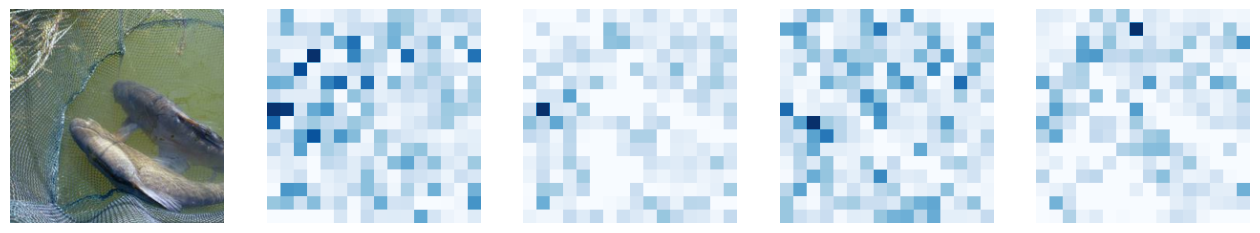

In [13]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 5, 1)
plt.imshow(img_)
plt.axis("off")
for i in range(4):
    plot = diff[:, top_channels[i:i+1]]
    plot = F.interpolate(plot, scale_factor=16, mode="area")[0, 0].cpu().numpy()
    plot = normalize(plot)
    plt.subplot(1, 5, i+2)
    plt.imshow(plot, cmap="Blues")
    plt.axis("off")